<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>
Using matplotlib as 2D backend.


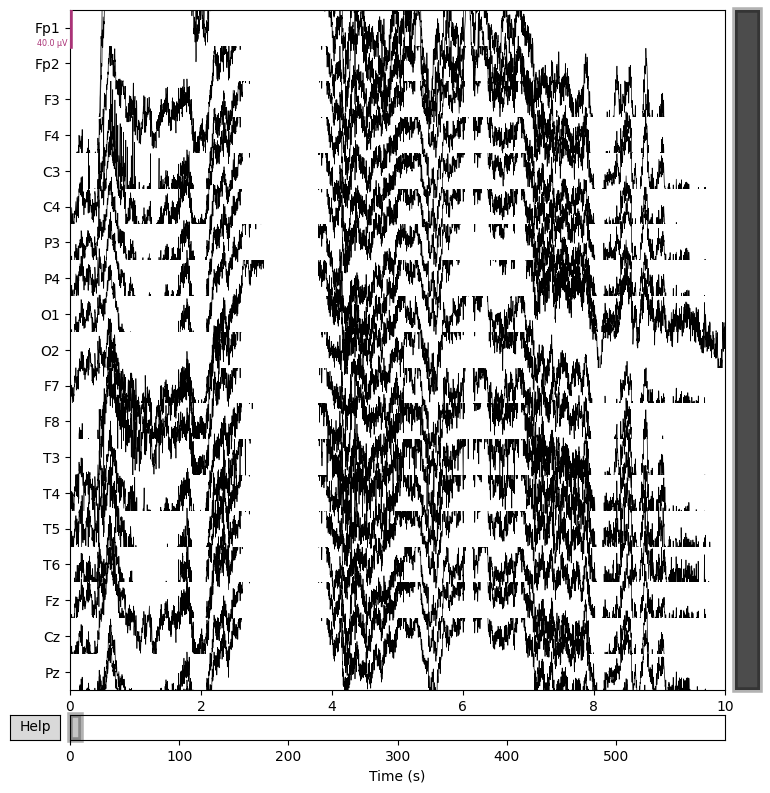

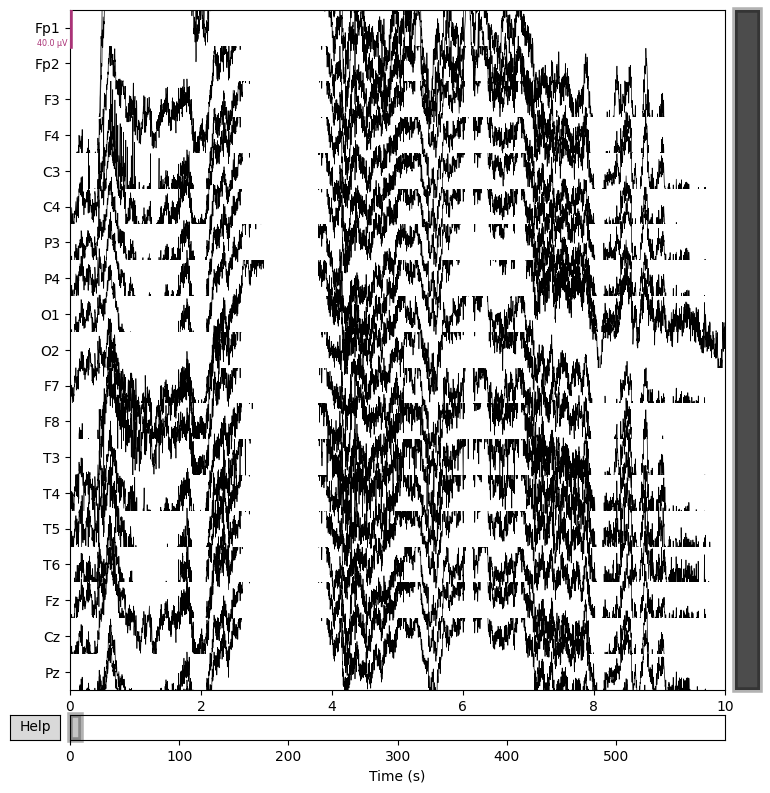

In [2]:
import mne

eeg_file_raw = "/Users/keishi/Documents/NakaguchiLab/Thai-Project/ds004504/sub-001/eeg/sub-001_task-eyesclosed_eeg.set"

raw_eeg = mne.io.read_raw_eeglab(eeg_file_raw, preload=True)

print(raw_eeg .info)

raw_eeg .plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


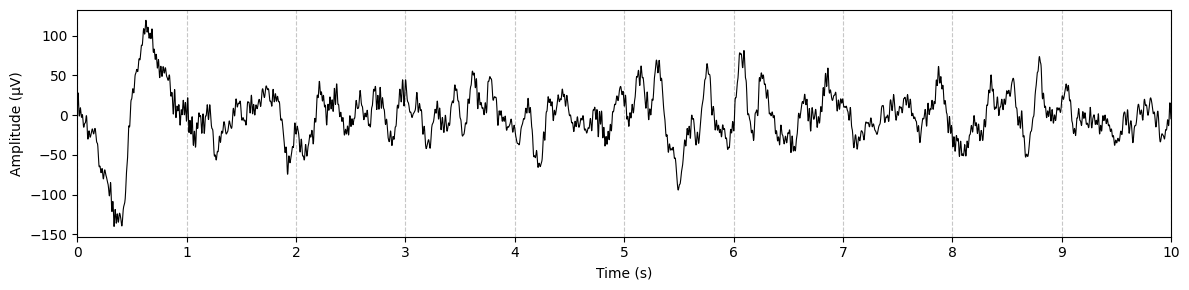

In [6]:
import matplotlib.pyplot as plt

# 1. フィルタリング（これで「普通の脳波」のようなきれいな波形になります）
# 1Hz以下(ドリフト)と50Hz以上(高周波ノイズ)をカット
raw_eeg.filter(l_freq=1.0, h_freq=50.0)

# 2. データの取得 (例: Fp1チャンネルを最初の10秒間だけ)
duration = 10  # 何秒分表示するか
data, times = raw_eeg.get_data(
    picks=['Fp1'], 
    tmax=duration, 
    return_times=True
)
# dataは (チャンネル数, サンプル数) の形なので、data[0]を取り出す
amplitude = data[0] * 1e6  # 単位を V(ボルト) から uV(マイクロボルト) に変換

# 3. シンプルに描画
plt.figure(figsize=(12, 3))  # 横長で見やすいサイズに
plt.plot(times, amplitude, color='black', linewidth=0.8)

# 横軸の設定：0からdurationまで、1秒刻みでグリッド線を引く
plt.xticks(range(0, duration + 1, 1))  # 0, 1, 2, ... 10
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.xlim(0, duration)  # 端をきれいに合わせる
plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # 1秒ごとの縦線を入れる

plt.tight_layout()
plt.show()

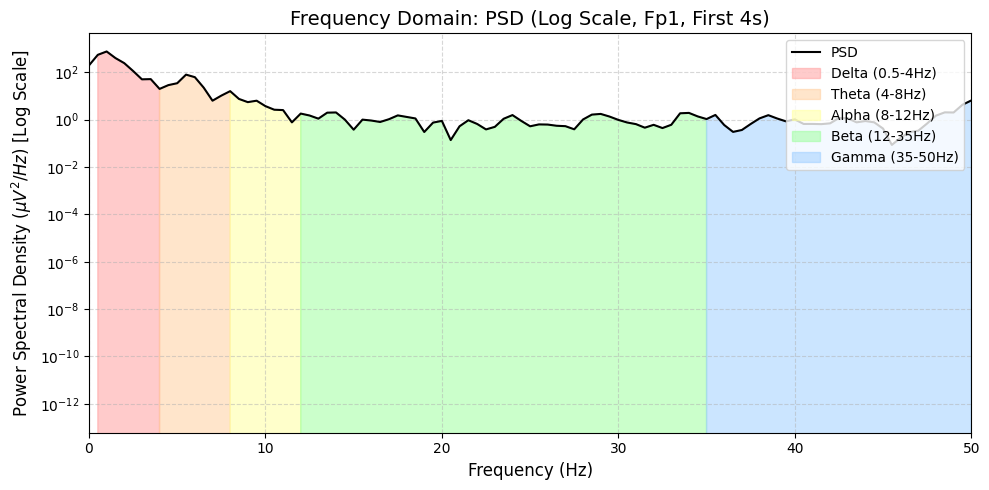

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ---------------------------------------------------------
# 1. データの準備 (前のセルでフィルタ済みの raw_eeg を使用)
# ---------------------------------------------------------
# Fp1チャンネル, 最初の4秒間 (=1エポック) だけ切り出す
# ※ 前のセルで raw_eeg が定義され、フィルタ済みであることを前提とします
if 'raw_eeg' not in locals():
     raise NameError("raw_eeg が定義されていません。データを読み込み、フィルタリングするセルを先に実行してください。")

data, times = raw_eeg.get_data(picks=['Fp1'], tmax=4, return_times=True)
signal_data = data[0] * 1e6 # uV単位
fs = int(raw_eeg.info['sfreq']) # 500Hz

# ---------------------------------------------------------
# 2. Welch法でPSDを計算
# ---------------------------------------------------------
freqs, psd = welch(signal_data, fs=fs, nperseg=fs*2)

# ---------------------------------------------------------
# 3. 描画 (Y軸を対数スケールに変更)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

# メインのPSDプロット
plt.plot(freqs, psd, color='black', linewidth=1.5, label='PSD')

# ===== ここが変更点：Y軸を対数にする =====
plt.yscale('log')
# ==========================================

# 帯域の定義
bands = {
    'Delta (0.5-4Hz)': (0.5, 4, '#FF9999'),   # 赤
    'Theta (4-8Hz)': (4, 8, '#FFCC99'),     # オレンジ
    'Alpha (8-12Hz)': (8, 12, '#FFFF99'),    # 黄
    'Beta (12-35Hz)': (12, 35, '#99FF99'),   # 緑
    'Gamma (35-50Hz)': (35, 50, '#99CCFF')   # 青
}

# 各帯域を塗りつぶす
for label, (low, high, color) in bands.items():
    idx = np.logical_and(freqs >= low, freqs <= high)
    plt.fill_between(freqs, psd, where=idx, color=color, alpha=0.5, label=label)

# グラフの体裁
plt.xlim(0, 50)
plt.xlabel('Frequency (Hz)', fontsize=12)
# ラベルに対数であることを追記
plt.ylabel('Power Spectral Density ($\mu V^2/Hz$) [Log Scale]', fontsize=12)
plt.title('Frequency Domain: PSD (Log Scale, Fp1, First 4s)', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
# 対数軸のグリッドは見やすいように変更
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()